# Temporal GNN Model for Single-Camera MOT
In this notebook, we finally train a graph neural network on the generated graph dataset. Keep in mind that a single-camera MOT scenario is considered.

In [2]:
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.utils import to_dense_adj,to_undirected
import torch
from torch.nn import Sigmoid

### 1. Load the Temporal Graph Dataset
Before defining the GNN model we load the dataset that we created in a previous tutorial and split it according to a predefined ratio.

In [4]:
tg_dataset = torch.load('/home/ge93qew/PycharmProjects/Forschungspraxis/jupyter-notebooks/tg_dataset.pt')
for i in tg_dataset:
    print(i)

train_dataset, test_dataset = temporal_signal_split(tg_dataset, train_ratio=0.8)

Data(x=[32, 2048], edge_index=[0], edge_attr=[0], edge_labels=[0])
Data(x=[63, 2048], edge_index=[2, 992], edge_attr=[992], edge_labels=[992])
Data(x=[93, 2048], edge_index=[2, 2882], edge_attr=[2882], edge_labels=[2882])
Data(x=[126, 2048], edge_index=[2, 5951], edge_attr=[5951], edge_labels=[5951])
Data(x=[159, 2048], edge_index=[2, 10109], edge_attr=[10109], edge_labels=[10109])
Data(x=[192, 2048], edge_index=[2, 15356], edge_attr=[15356], edge_labels=[15356])
Data(x=[222, 2048], edge_index=[2, 21116], edge_attr=[21116], edge_labels=[21116])
Data(x=[252, 2048], edge_index=[2, 27776], edge_attr=[27776], edge_labels=[27776])
Data(x=[283, 2048], edge_index=[2, 35588], edge_attr=[35588], edge_labels=[35588])
Data(x=[314, 2048], edge_index=[2, 44361], edge_attr=[44361], edge_labels=[44361])


### 2. Define the GNN Model

In [23]:
epochs = 100
lr = 0.0001
weight_decay = 5e-4
n_heads_sal = 4
n_out_sal = 128

### 2. Define Custom Temporal Attention Layer
Inspired by the [DyGLIP](https://arxiv.org/abs/2106.06856) paper, let's use 2 structural attention layers in our model. We calculate the cosinus distance to get similarity metrics and pass it to a sigmoid classifier. Since we are only interested in existing edges, we apply a mask derived from the adjacency matrix of our graph. I had the following issues during the training:
- the attention coefficients were not being updated
- the loss was not decreasing at all 

The main reason for this finding is that the loss gradient has been `None` - but how is that even possible? Well, here are some of my mistakes and greatest learnings: 
- Don't mess with PyTorch's autograd engine 
- Try to use as many functions provided by PyTorch (avoid e.g. numpy)
- Avoid for loops (but that is a general advise)
- Even using functions provided by PyTorch might cause some problems (in my case I had some problems with stacking tensors together)

And finally, I came up with the following model.

In [6]:
class Model(torch.nn.Module):
    def __init__(self, in_feat_size):
        super(Model, self).__init__()
        self.sal1 = GATv2Conv(in_feat_size, out_channels=n_out_sal, heads=n_heads_sal, edge_dim=1)
        self.sal2 = GATv2Conv(in_channels=n_out_sal * n_heads_sal, out_channels=n_out_sal, heads=n_heads_sal,
                              edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        h1 = self.sal1(x, edge_index, edge_attr)
        h2 = self.sal2(h1, edge_index, edge_attr)

        norm_row = torch.linalg.norm(h2, dim=1)
        scaling = torch.outer(norm_row, norm_row)
        cos_dist = torch.matmul(h2, torch.transpose(h2, 0, 1)) / scaling

        sig = Sigmoid()
        scores = sig(cos_dist)
       
        mask = to_dense_adj(edge_index).type(torch.bool)
        labels = torch.masked_select(scores, mask)

        return labels

We choose our loss function and optimizer to be the binary cross entropy loss and the adam optimizer. Note: the argument `input_feat_size` is 2048 since we get 2048 ReID features from the ResNet-50.

In [7]:
model = Model(in_feat_size=2048)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

Define the training loop.

In [8]:
def train_loop(train_dataset, model, loss_fn, optimizer):
    running_loss = 0
    n_snapshots = train_dataset.snapshot_count
    for time, snapshot in enumerate(train_dataset):
        if time > 0:
            optimizer.zero_grad()
            
            pred = model(snapshot.x,snapshot.edge_index,snapshot.edge_attr)
            target = snapshot.edge_labels.to(torch.float32)
            
            loss = loss_fn(pred, target)
            loss.backward()  
            
            optimizer.step()

            loss = loss.item()
            running_loss = running_loss + loss
            print(f"train loss: {loss:>7f}  [{time}/{n_snapshots-1}]")
    avg_loss = running_loss / (n_snapshots-1)
    print(f'avg_train_loss: {avg_loss}')
    return avg_loss

Define the test loop.

In [9]:
def test_loop(test_dataset, model, loss_fn):
    running_loss, correct = 0, 0
    n_snapshots = test_dataset.snapshot_count

    with torch.no_grad():
        for snapshot in test_dataset:
            size = snapshot.edge_labels.size(dim=0)

            pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            target = snapshot.edge_labels.to(torch.float32)
            test_loss = loss_fn(pred, target).item()
            
            correct = pred.size(dim=0) - torch.abs((pred - target)).sum().item()
            correct = correct / size
            
            print(f"accuracy: {(100 * correct):>0.1f}%, \ntest loss: {test_loss:>8f}")
            running_loss = running_loss + test_loss
        avg_loss = running_loss / n_snapshots
        print(f'avg_test_loss: {avg_loss}')
        return avg_loss

Train and test the model for a given number of epochs. 

In [ ]:
train_losses = []
test_losses =  []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_l = train_loop(train_dataset, model, loss_fn, optimizer)
    test_l = test_loop(test_dataset, model, loss_fn)
    print(f"\n")

    train_losses.append(train_l)
    test_losses.append(test_l)
print("Done!")

After 100 epochs I get `avg_train_loss`: 0.5783409305981227, 
`avg_test_loss`: 0.7038484215736389,`accuracy`: accuracy: 50.65%.

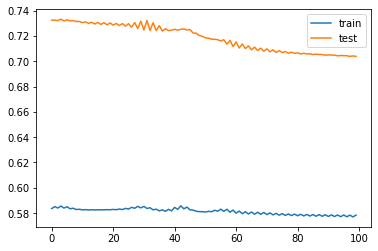

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend(loc="upper right")
plt.show()